# Where should I move? by Preet Mishra

Objective: To find a neighbourhood for person X who wants to move to Toronto based on his/her preferences of venues. 

Data Sources: 
- Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
 
- csv file of Toronto Neighborhood coordinates (http://cocl.us/Geospatial_data)
- Foursquare (http://foursquare.com)

GitHub repository:

https://github.com/preetmishra/ibm_data_science_projects/tree/master/Applied%20Data%20Science%20Capstone/Where%20should%20I%20move%3F

----------

#### Importing the required libraries.

In [145]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
# !conda install -c conda-forge folium=0.5.0
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import folium 
from geopy.geocoders import Nominatim
print('Libraries imported.')

Libraries imported.


### Scraping

Scraping the data about the neighbourhoods of Toronto from _Wikipedia_

In [146]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text

In [147]:
soup = BeautifulSoup(source, 'html.parser')
rows = soup.body.table.tbody.text.split('\n\n\n')
data = []
for row in rows :
    cell = row.split('\n')
    if len(cell) == 3 :
        data.append(cell)
print('Number of neighbourhoods scraped: ', len(data))        
data[:5]

Number of neighbourhoods scraped:  287


[['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront']]

Now that we have the data let's clean it up for our use.


### Cleaning/Wrangling the data

Let's create a pandas dataframe to handle the data in a convenient manner

In [148]:
df = pd.DataFrame(data, columns = ['PostalCode', 'Borough', 'Neighbourhood'])
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


The Borough and Neighbourhood which are _'Not assigned'_ are not really of use to us. So let's delete those rows.

In [149]:
df = df[df['Borough'] != "Not assigned"].reset_index()

In [150]:
df.drop('index', axis = 1, inplace = True)

In [151]:
print(df.shape)
df.head()

(211, 3)


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


Looks good. Let's combine the neighbourhoods of the same borough together.

In [152]:
df = df.groupby(['PostalCode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

In [153]:
print(df.shape)
df.head()

(103, 3)


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Now that we have our dataframe intact. Let's add their longitude and latitude from a csv file.

In [154]:
geo_data = pd.read_csv('http://cocl.us/Geospatial_data')
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [155]:
geo_data.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_data.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging this geo_data dataframe with our dataframe.

In [156]:
df = pd.merge(df, geo_data, on='PostalCode')

In [157]:
print(df.shape)
df.head()

(103, 5)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Let's plot these on a map to have a better idea of different areas in Toronto. 

In [158]:
# using geopy to calculate the geograpical coordinate of Toronto
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Map of Toronto with the neighbourhoods

In [159]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding markers to the map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Exploring the neighbourhoods

Now we will use the _Foursquare API_ to gain the details of the venues available 

Defining Foursquare Credentials and Version

In [160]:
 # @hidden_cell
CLIENT_ID = 'CC1TDLVJ0QD2NYFFRPVT1AWJ2LFOEM2YNF50JG2N2RAJN33R'
CLIENT_SECRET = 'G5SNMHY4YQX1R144FDGJXZWHNPV1MEZJHHMD1UE0Y5BBMBQH' 
VERSION = '20180605' 

Let's define a function for getting the nearby venues of a neighbourhood to get the nearby venues

In [161]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Getting the venues

In [162]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [163]:
print(toronto_venues.shape)
toronto_venues.head()

(2235, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


Let's see how many venues were returned by each neighbourhood

In [164]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",10,10,10,10,10,10
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,55,55,55,55,55,55


### Analysing the neighbourhoods

In [165]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] =toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2235, 274)


,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,

Now, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [166]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(98, 274)


,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.01,0.0,0.0

Let's see 5 most venue types of each neighbourhood

In [167]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.06
1              Bar  0.04
2             Café  0.04
3  Thai Restaurant  0.04
4       Steakhouse  0.04


----Agincourt----
            venue  freq
0    Skating Rink  0.25
1          Lounge  0.25
2  Breakfast Spot  0.25
3  Sandwich Place  0.25
4  Massage Studio  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                 venue  freq
0           Playground   0.5
1                 Park   0.5
2   Mexican Restaurant   0.0
3                Motel   0.0
4  Monument / Landmark   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                 venue  freq
0        Grocery Store   0.2
1          Pizza Place   0.1
2         Liquor Store   0.1
3  Fried Chicken Joint   0.1
4          Coffee Shop   0.1


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place   0.2
1            Pool   0.1
2    Skating 

                venue  freq
0      Discount Store  0.17
1   Convenience Store  0.17
2         Bus Station  0.17
3  Chinese Restaurant  0.17
4         Coffee Shop  0.17


----East Toronto----
                venue  freq
0                Park  0.50
1   Convenience Store  0.25
2         Coffee Shop  0.25
3   Accessories Store  0.00
4  Miscellaneous Shop  0.00


----Emery, Humberlea----
                           venue  freq
0  Paper / Office Supplies Store   0.5
1                 Baseball Field   0.5
2              Accessories Store   0.0
3      Middle Eastern Restaurant   0.0
4                          Motel   0.0


----Fairview, Henry Farm, Oriole----
                  venue  freq
0        Clothing Store  0.17
1  Fast Food Restaurant  0.08
2           Coffee Shop  0.06
3            Restaurant  0.05
4              Tea Room  0.03


----First Canadian Place, Underground city----
         venue  freq
0  Coffee Shop  0.08
1         Café  0.07
2        Hotel  0.06
3   Steakhouse  0.04
4   Res

                       venue  freq
0                 Playground   1.0
1  Middle Eastern Restaurant   0.0
2              Movie Theater   0.0
3                      Motel   0.0
4        Monument / Landmark   0.0


----St. James Town----
            venue  freq
0     Coffee Shop  0.07
1      Restaurant  0.06
2            Café  0.05
3           Hotel  0.05
4  Clothing Store  0.04


----Stn A PO Boxes 25 The Esplanade----
                venue  freq
0         Coffee Shop  0.10
1          Restaurant  0.04
2                Café  0.04
3  Seafood Restaurant  0.03
4                 Pub  0.03


----Studio District----
                venue  freq
0                Café  0.10
1         Coffee Shop  0.08
2           Gastropub  0.05
3  Italian Restaurant  0.05
4              Bakery  0.05


----The Annex, North Midtown, Yorkville----
                           venue  freq
0                 Sandwich Place  0.12
1                           Café  0.12
2                    Coffee Shop  0.12
3              

Let's put this into a pandas dataframe

In [168]:
# function to return most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [169]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Burger Joint,Gym,Asian Restaurant,Hotel,Bakery
1,Agincourt,Lounge,Sandwich Place,Breakfast Spot,Skating Rink,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Yoga Studio,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Fried Chicken Joint,Coffee Shop,Sandwich Place,Fast Food Restaurant,Beer Store,Liquor Store,Pharmacy,Dance Studio
4,"Alderwood, Long Branch",Pizza Place,Skating Rink,Dance Studio,Pharmacy,Coffee Shop,Pool,Pub,Sandwich Place,Gym,Airport Terminal


Now that we have everything in place let's cluster the neighbourhoods together

### Clustering neighbourhoods using k-Means

In [170]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

Let's choose best k using elbow method

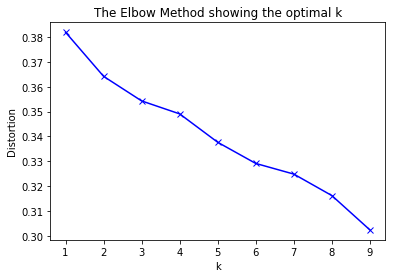

In [171]:
distortions = []
K = range(1,10)
for k in K:
    kmeansModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeansModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Let's go with k = 5

In [172]:
kclusters = 5

# k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2], dtype=int32)

Adding cluster's label to our dataframe 

In [173]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Hardware Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,3.0,Bar,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Pizza Place,Breakfast Spot,Rental Car Location,Intersection,Mexican Restaurant,Medical Center,Electronics Store,Spa,Eastern European Restaurant,Dumpling Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka Restaurant,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Bakery,Bank,Fried Chicken Joint,Yoga Studio,Donut Shop,Dog Run


In [174]:
toronto_merged = toronto_merged[np.isfinite(toronto_merged['Cluster Labels'])].reset_index(drop=True)

In [175]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Hardware Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,3,Bar,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Pizza Place,Breakfast Spot,Rental Car Location,Intersection,Mexican Restaurant,Medical Center,Electronics Store,Spa,Eastern European Restaurant,Dumpling Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Hakka Restaurant,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Bakery,Bank,Fried Chicken Joint,Yoga Studio,Donut Shop,Dog Run
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,0,Discount Store,Chinese Restaurant,Bus Station,Department Store,Coffee Shop,Convenience Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,0,Bus Line,Bakery,Fast Food Restaurant,Intersection,Bus Station,Soccer Field,Park,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,0,Motel,Movie Theater,American Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0,College Stadium,General Entertainment,Skating Rink,Café,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop


### Visualizing the clusters

In [176]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining the clusters and finding their representative

Now for each of the clusters we will find a representative.

> Representatives are the neighbourhoods whose top venues are _most likely_ to resemble with each of the neighbourhoods in that particular cluster.

In [177]:
closest, _ = metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_, toronto_grouped_clustering)
closest

array([78,  2, 16, 53, 42])

In [178]:
# function to get venues by their frequency in descending order
def get_venues_by_freq(val, repindex) :
    num_top_venues = val
    print(toronto_grouped.iloc[repindex, 0].upper()+': ' )
    temp = toronto_grouped.iloc[repindex, :].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

## Cluster 1
-----

In [179]:
cluster1_df  = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster1_df

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge, Malvern",0,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Hardware Store
2,"Guildwood, Morningside, West Hill",0,Pizza Place,Breakfast Spot,Rental Car Location,Intersection,Mexican Restaurant,Medical Center,Electronics Store,Spa,Eastern European Restaurant,Dumpling Restaurant
3,Woburn,0,Coffee Shop,Korean Restaurant,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,Cedarbrae,0,Hakka Restaurant,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Bakery,Bank,Fried Chicken Joint,Yoga Studio,Donut Shop,Dog Run
6,"East Birchmount Park, Ionview, Kennedy Park",0,Discount Store,Chinese Restaurant,Bus Station,Department Store,Coffee Shop,Convenience Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
7,"Clairlea, Golden Mile, Oakridge",0,Bus Line,Bakery,Fast Food Restaurant,Intersection,Bus Station,Soccer Field,Park,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
8,"Cliffcrest, Cliffside, Scarborough Village West",0,Motel,Movie Theater,American Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
9,"Birch Cliff, Cliffside West",0,College Stadium,General Entertainment,Skating Rink,Café,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
10,"Dorset Park, Scarborough Town Centre, Wexford ...",0,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Furniture / Home Store,Chinese Restaurant,Pet Store,Concert Hall,Dim Sum Restaurant,Event Space,Ethiopian Restaurant
11,"Maryvale, Wexford",0,Auto Garage,Middle Eastern Restaurant,Smoke Shop,Breakfast Spot,Sandwich Place,Shopping Mall,Donut Shop,Discount Store,Dog Run,Doner Restaurant


#### Representative of Cluster 1 

In [180]:
get_venues_by_freq(20, closest[0])

RYERSON, GARDEN DISTRICT: 
                        venue  freq
0                 Coffee Shop  0.08
1              Clothing Store  0.06
2              Cosmetics Shop  0.04
3                        Café  0.04
4   Middle Eastern Restaurant  0.03
5             Thai Restaurant  0.02
6                 Pizza Place  0.02
7                         Bar  0.02
8                    Tea Room  0.02
9             Bubble Tea Shop  0.02
10                    Theater  0.02
11        Japanese Restaurant  0.02
12             Lingerie Store  0.02
13                      Diner  0.02
14         Italian Restaurant  0.02
15           Ramen Restaurant  0.02
16                 Restaurant  0.02
17       Fast Food Restaurant  0.01
18         Chinese Restaurant  0.01
19               Dessert Shop  0.01




## Cluster 2
-----

In [181]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough Village,1,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
14,"Agincourt North, L'Amoreaux East, Milliken, St...",1,Playground,Park,Yoga Studio,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
45,"Moore Park, Summerhill East",1,Playground,Gym,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore


#### Representative of Cluster 2

In [182]:
get_venues_by_freq(20, closest[1])

AGINCOURT NORTH, L'AMOREAUX EAST, MILLIKEN, STEELES EAST: 
                              venue  freq
0                        Playground   0.5
1                              Park   0.5
2                Mexican Restaurant   0.0
3                             Motel   0.0
4               Monument / Landmark   0.0
5   Molecular Gastronomy Restaurant   0.0
6        Modern European Restaurant   0.0
7                Miscellaneous Shop   0.0
8         Middle Eastern Restaurant   0.0
9                       Men's Store   0.0
10                           Museum   0.0
11         Mediterranean Restaurant   0.0
12                   Medical Center   0.0
13                   Massage Studio   0.0
14                Martial Arts Dojo   0.0
15                           Market   0.0
16                    Movie Theater   0.0
17                      Music Store   0.0
18                Health Food Store   0.0
19                      Music Venue   0.0




## Cluster 3
-----

In [183]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,York Mills West,2,Park,Bank,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
22,Parkwoods,2,Fast Food Restaurant,Park,Food & Drink Shop,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
27,"CFB Toronto, Downsview East",2,Bus Stop,Park,Airport,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
37,East Toronto,2,Park,Coffee Shop,Convenience Store,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
41,Lawrence Park,2,Gym / Fitness Center,Park,Bus Line,Swim School,Yoga Studio,Drugstore,Discount Store,Dog Run,Doner Restaurant,Donut Shop
47,Rosedale,2,Park,Trail,Playground,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
71,Caledonia-Fairbanks,2,Park,Fast Food Restaurant,Market,Pharmacy,Women's Store,Grocery Store,Department Store,Gym,Empanada Restaurant,Electronics Store
76,"Downsview, North Park, Upwood Park",2,Basketball Court,Park,Construction & Landscaping,Bakery,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
87,"The Kingsway, Montgomery Road, Old Mill North",2,Park,River,Smoke Shop,Pool,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
95,"Kingsview Village, Martin Grove Gardens, Richv...",2,Pizza Place,Park,Bus Line,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


#### Representative of Cluster 3

In [184]:
get_venues_by_freq(20, closest[2])

CALEDONIA-FAIRBANKS: 
                              venue  freq
0                              Park  0.33
1                     Women's Store  0.17
2                          Pharmacy  0.17
3                            Market  0.17
4              Fast Food Restaurant  0.17
5                 Accessories Store  0.00
6                Mexican Restaurant  0.00
7               Monument / Landmark  0.00
8   Molecular Gastronomy Restaurant  0.00
9        Modern European Restaurant  0.00
10               Miscellaneous Shop  0.00
11        Middle Eastern Restaurant  0.00
12                   Medical Center  0.00
13                      Men's Store  0.00
14         Mediterranean Restaurant  0.00
15                    Movie Theater  0.00
16                   Massage Studio  0.00
17                Martial Arts Dojo  0.00
18                            Motel  0.00
19                      Music Store  0.00




## Cluster 4
-----

In [185]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland Creek, Rouge Hill, Port Union",3,Bar,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field


#### Representative of Cluster 4

In [186]:
get_venues_by_freq(20, closest[3])

HIGHLAND CREEK, ROUGE HILL, PORT UNION: 
                              venue  freq
0                               Bar   1.0
1                 Accessories Store   0.0
2         Middle Eastern Restaurant   0.0
3                             Motel   0.0
4               Monument / Landmark   0.0
5   Molecular Gastronomy Restaurant   0.0
6        Modern European Restaurant   0.0
7                Miscellaneous Shop   0.0
8                Mexican Restaurant   0.0
9                            Museum   0.0
10                      Men's Store   0.0
11         Mediterranean Restaurant   0.0
12                   Medical Center   0.0
13                   Massage Studio   0.0
14                Martial Arts Dojo   0.0
15                           Market   0.0
16                    Movie Theater   0.0
17                      Music Store   0.0
18               Mac & Cheese Joint   0.0
19                  Organic Grocery   0.0




## Cluster 5
-----

In [187]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
88,"Humber Bay, King's Mill Park, Kingsway Park So...",4,Baseball Field,Pool,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
93,"Emery, Humberlea",4,Baseball Field,Paper / Office Supplies Store,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


#### Representative of Cluster 5

In [188]:
get_venues_by_freq(20, closest[4])

EMERY, HUMBERLEA: 
                              venue  freq
0     Paper / Office Supplies Store   0.5
1                    Baseball Field   0.5
2                 Accessories Store   0.0
3         Middle Eastern Restaurant   0.0
4                             Motel   0.0
5               Monument / Landmark   0.0
6   Molecular Gastronomy Restaurant   0.0
7        Modern European Restaurant   0.0
8                Miscellaneous Shop   0.0
9                Mexican Restaurant   0.0
10                           Museum   0.0
11                      Men's Store   0.0
12         Mediterranean Restaurant   0.0
13                   Medical Center   0.0
14                   Massage Studio   0.0
15                Martial Arts Dojo   0.0
16                           Market   0.0
17                    Movie Theater   0.0
18                      Music Store   0.0
19               Mac & Cheese Joint   0.0




>  ### We have successfully divided the neighbourhoods in five clusters based on the venues.
A person X who wants to move to Toronto can choose a neighbourhood from different clusters. For choosing a particular cluster, X can analyze provided cluster's _representative_ based on his/her preferences of venues. 
+ Each neighbourhood of the cluster is _most likely_ to have similar characteristics as the cluster's representative. 